In [2]:
!pip install openai-whisper gradio pandas openpyxl


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 803.2/803.2 kB 12.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 170.5/170.5 MB 7.4 MB/s eta 0:00:00
  Created wheel for openai-whisper: filename=openai_whisper-20250625-py3-none-any.whl size=803979 sha256=1531ee681ad937cdadc6f1670f596244e1f401838b883a214522c4310555549b
  Stored in directory: /root/.cache/pip/wheels/61/d2/20/09ec9bef734d126cba375b15898010b6cc28578d8afdde5869
Successfully built openai-whisper


In [22]:
import whisper

model = whisper.load_model("base")
result = model.transcribe("/content/drive/MyDrive/sid2.ogg")
transcript = result["text"]


/usr/local/lib/python3.12/dist-packages/whisper/transcribe.py:132: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


In [23]:
from transformers import pipeline

summarizer = pipeline(
    "summarization",
    model="facebook/bart-large-cnn"
)

summary = summarizer(
    transcript,
    max_length=150,
    min_length=20,
    do_sample=False
)[0]["summary_text"]

print(summary)


Device set to use cpu
Your max_length is set to 150, but your input_length is only 41. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=20)


I want tiles which color of which size I want two by two of color green tiles. Yes, we can give you send your contact details. Thank you.


In [24]:
intent_prompt = f"""
Classify the intent of this call into one of:
- Product Inquiry
- Support Issue
- Purchase
- Complaint
- Not Interested

Call:
{transcript}
"""

classifier = pipeline(
    "zero-shot-classification",
    model="facebook/bart-large-mnli"
)

intent = classifier(
    transcript,
    candidate_labels=[
        "Product Inquiry",
        "Support Issue",
        "Purchase",
        "Complaint",
        "Not Interested"
    ]
)

print(intent["labels"][0])


Device set to use cpu


Complaint


In [25]:
intent_label = intent["labels"][0]

if intent_label == "Purchase":
    lead = "Hot"
elif intent_label in ["Product Inquiry", "Support Issue"]:
    lead = "Warm"
else:
    lead = "Cold"

print("Lead Type:", lead)


Lead Type: Cold


In [26]:
from google.colab import auth
auth.authenticate_user()


In [15]:
!pip install gspread pandas matplotlib


In [16]:
import gspread
from google.auth import default

creds, _ = default()
gc = gspread.authorize(creds)

# Create or open sheet
sheet = gc.create("AI Call Analysis")
worksheet = sheet.sheet1

# Add headers
worksheet.append_row([
    "Transcript",
    "Summary",
    "Intent",
    "Lead Type"
])


{'spreadsheetId': '152ByugUCm5xvm-8WyqYKt5QE-TXDefSy_xnLsiAOJng',
 'updates': {'spreadsheetId': '152ByugUCm5xvm-8WyqYKt5QE-TXDefSy_xnLsiAOJng',
  'updatedRange': 'Sheet1!A1:D1',
  'updatedRows': 1,
  'updatedColumns': 4,
  'updatedCells': 4}}

In [28]:
worksheet.append_row([
    transcript,
    summary,
    intent_label,
    lead
])


{'spreadsheetId': '152ByugUCm5xvm-8WyqYKt5QE-TXDefSy_xnLsiAOJng',
 'tableRange': 'Sheet1!A1:D2',
 'updates': {'spreadsheetId': '152ByugUCm5xvm-8WyqYKt5QE-TXDefSy_xnLsiAOJng',
  'updatedRange': 'Sheet1!A3:D3',
  'updatedRows': 1,
  'updatedColumns': 4,
  'updatedCells': 4}}

Lead Type
Warm    1
Name: count, dtype: int64


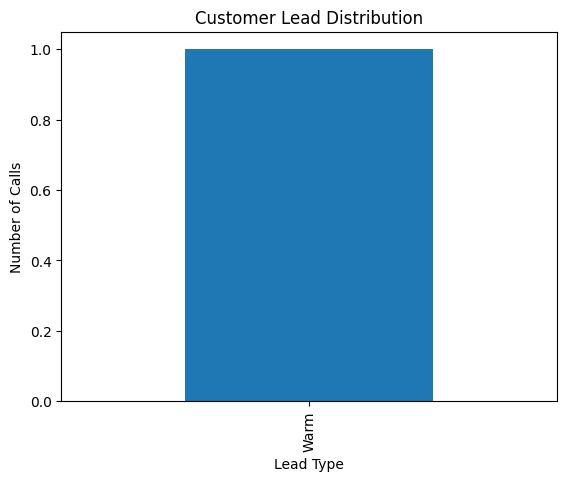

In [27]:
import pandas as pd

data = worksheet.get_all_records()
df = pd.DataFrame(data)

lead_counts = df["Lead Type"].value_counts()
print(lead_counts)


import matplotlib.pyplot as plt

plt.figure()
lead_counts.plot(kind="bar")
plt.title("Customer Lead Distribution")
plt.xlabel("Lead Type")
plt.ylabel("Number of Calls")
plt.show()
